* https://github.com/DavideAltomare/ChannelAttribution/blob/master/python/README.md
* https://github.com/eeghor/mta
* https://www.reddit.com/r/marketing/comments/11r2y6g/how_do_big_organizations_handle_marketing/
* https://channelattribution.io/
* https://pypi.org/project/ChannelAttribution/
* https://medium.com/@davide.altomare/multi-touch-attribution-and-budget-allocation-ce04b492604d

# Attribution Modeling

In [185]:
import pandas as pd
import numpy as np
from ChannelAttribution import *

import plotly.express as px
import plotly.io as pio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

In [186]:
df = pd.read_csv('attribution data.csv')

* Cookie: Anonymous customer id enabling us to track the progression of a given customer
* Timestamp: Date and time when the visit took place
* Interaction: Categorical variable indicating the type of interaction that took place
* Conversion: Boolean variable indicating whether a conversion took place
* Conversion Value: Value of the potential conversion event (revenue)
* Channel: The marketing channel that brought the customer to our site

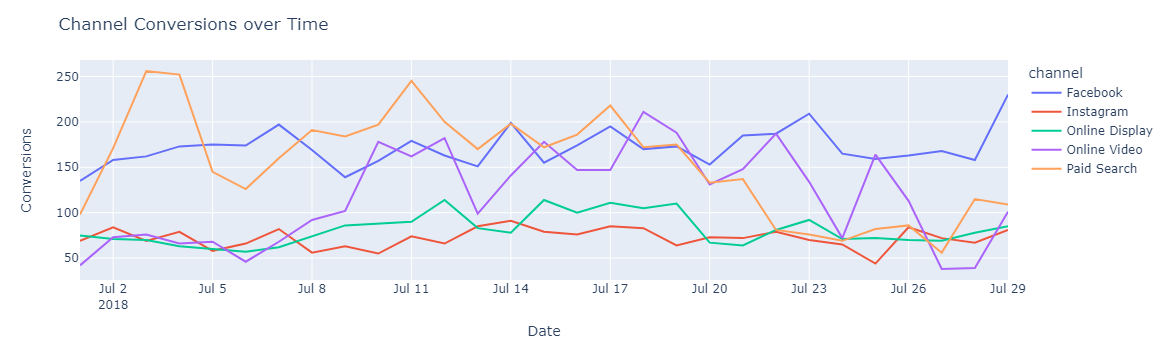

In [187]:
# Convert the 'time' column to datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Filter conversions and set 'time' to date
conversions = df[df['conversion'] == 1].copy()
conversions['time'] = conversions['time'].dt.date
conversions = conversions[conversions['time'] < pd.to_datetime("2018-07-30").date()]
conversions.drop(columns=['cookie', 'interaction'], inplace=True)

# Group by 'time' and 'channel' and sum
conversions = conversions.groupby(['time', 'channel'], as_index=False).sum()

# Create the plot
fig = px.line(conversions, x='time', y='conversion', color='channel')

fig.update_layout(
    title='Channel Conversions over Time',
    xaxis_title='Date',
    yaxis_title='Conversions'
)

fig.show()


# Prepare Data for Modeling

#### 1. Create path for each user 

In [188]:
# basically groups all unique cookies into groups, so for example cookie a could have 5 rows, 
# and since this is ordered by date, the cookie is sequential, and it is indexed from 0 - x. 
# his way we can track how the cookie aka user intereacted with different channels throughout time
df['path_order'] = df.sort_values('time').groupby('cookie').cumcount()

In [189]:
# Example of a unique cookie / user and his / her path_order
df[df['cookie'] == '00000FkCnDfDDf0iC97iC703B']

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,0
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,1
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,2
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,3


#### 2. Aggregate channels a user interacted w/ into a single row
* as we can see, cookie 00000FkCnDfDDf0iC97iC703B with time went from IG - od - od, -od
* we convert this proecss into a list

In [190]:
df[['cookie','channel']].head(4)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,Instagram
1,00000FkCnDfDDf0iC97iC703B,Online Display
2,00000FkCnDfDDf0iC97iC703B,Online Display
3,00000FkCnDfDDf0iC97iC703B,Online Display


In [191]:
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={'channel':'path'})
df_paths.head(1)

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."


#### 3. Look at last interaction to see if it led to user conversion

In [192]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie','conversion','conversion_value']]

In [193]:
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [194]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


#### 5. Format path col to req. format for attribution model

In [195]:
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


#### 6. Remove user's cookie and group by path to see different combos of paths and their metrics

In [196]:
df_paths.drop(columns='cookie', inplace=True)
# Null col counts the combo's 0 conversions
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

In [197]:
attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", 
                               "null": "total_null", "conversion_value": 
                               "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
8548,Online Video > Online Video > Online Video > O...,61,383.5,259
9350,Paid Search > Facebook > Facebook > Online Dis...,0,0.0,1
5748,Instagram > Online Display > Online Display > ...,0,0.0,1
3081,Facebook > Instagram > Online Video > Online V...,0,0.0,1
4483,Instagram > Facebook > Facebook > Instagram > ...,0,0.0,1
7649,Online Video > Facebook > Instagram,2,12.5,49
7835,Online Video > Instagram > Instagram,0,0.0,17
7948,Online Video > Online Display > Online Video >...,1,5.5,7
2437,Facebook > Instagram > Facebook > Facebook > P...,0,0.0,4
8566,Online Video > Online Video > Online Video > O...,0,0.0,1


# Attriution Modeling

Advertisers use a variety of online marketing channels to reach consumers and they typically want to know how much each channel contributes to their marketing success. This is what is known as multi-channel attribution. In many cases, advertisers approach this problem using some simple heuristical models that often underestimate the importance of different marketing channels. In general, there are different types of attribution models:

* First Touch Conversion: A user's conversion is attributed to the first channels/touchpoints.
* Last Touch Conversion: A user's conversion is attributed to the last channels/touchpoints.
* Linear Touch Conversion: All channels/touchpoints are given equal credit to a user's conversion.
* Markov chains: A probabilistic model that represents the buyer's journey as a graph, with the nodes representing different channels/touchpoints, and the connecting lines being observed transitions between them. The number of times buyers have transitioned between two states is converted into a probability, which can then be used to measure the importance of each channel and the most likely channel paths to success.
Example Markov Chain where C denotes the marketing channel:

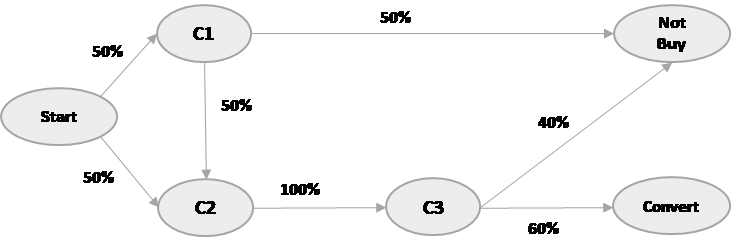

Parameters
----------
* Data : DataFrame
    customer journeys.
* var_path: string
    column of Data containing paths.
* var_conv : string
    column of Data containing total conversions for each path.
* var_value : string, optional, default None
    column of Data containing revenue for each path.
* sep : string, default ">"
    separator between the channels.
* flg_adv : bool, default True
    if True, ChannelAttribution Pro banner is printed.

In [198]:
#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product
Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


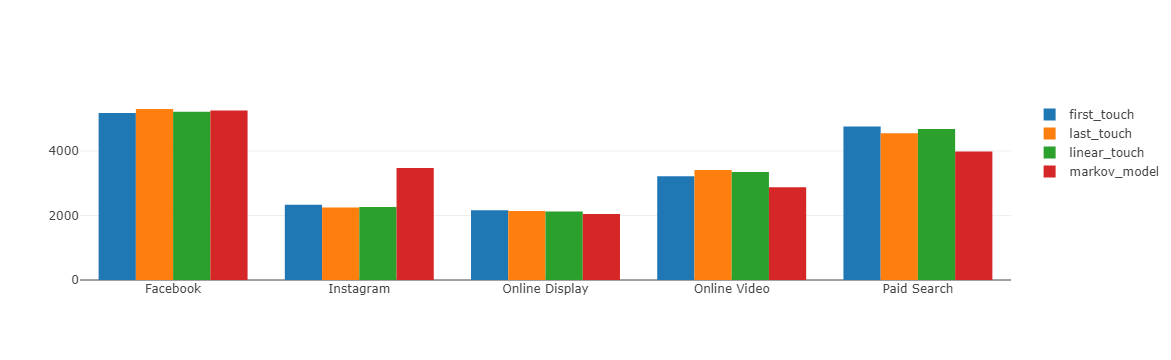

In [199]:
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions",\
"linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

data = [dict(type = "histogram", histfunc="sum",x = R1.channel_name, y = R1.value,
             transforms = [dict(type = "groupby", groups = R1.variable,)],)]

fig = dict({"data":data}) 
pio.show(fig,validate=False)

According to the heuristic models = first, last, and linear touch, faceook and paid search seem to provide most value into conversions. But According to the Markov model, instagram provides important value into facilitating the transition between different channels, an insight we would not have known without the Markov model. 

The reccomendation to the business is continue investing into facebook and paid search campaigns, but do not ignore instagram, they are important in connecting different channels together !

The Markov model works off of turning the transition of 2 stages into a probability, and Markov suggests that Instagram facilitates a lot of these transitions, providing value